# ロジスティック回帰アルゴリズム
ロジスティック回帰アルゴリズムをスクラッチで構築
1. データ取得
2. プロット
3. シグモイド関数について
4. 二乗誤差と交差エントロピー誤差について
5. 学習曲線のプロット
6. 予測関数について
7. クラス化

## 1. データ取得

データセット：Iris Species  
https://www.kaggle.com/uciml/iris/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
iris_df = pd.read_csv('input/Iris.csv')
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


- 総データ数：150
- IDを除いて４つの特徴量（がく片と花弁、それぞれの長さと幅）
- 欠損値なし
- 目的変数：カテゴリカルデータ
- 説明変数：数値

### ２値分類
今回は以下のクラスを分類（Iris-setosaを除外）
- Iris-versicolor
- Iris-virginica

In [3]:
# Iris-setosa除外
iris_df=iris_df[iris_df["Species"]!="Iris-setosa"]

# drop=True：旧インデックスのデータフレーム挿入回避
x_df=iris_df.drop(["Species","Id"], axis=1).reset_index(drop=True)
y_df=iris_df[["Species"]].reset_index(drop=True)

In [4]:
x_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,7.0,3.2,4.7,1.4
1,6.4,3.2,4.5,1.5
2,6.9,3.1,4.9,1.5
3,5.5,2.3,4.0,1.3
4,6.5,2.8,4.6,1.5


In [5]:
y_df.head()

,Species
0,Iris-versicolor
1,Iris-versicolor
2,Iris-versicolor
3,Iris-versicolor
4,Iris-versicolor


In [6]:
y_df["Species"].value_counts()

Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

## 2. プロット
### SepalLengthCm と SepalWidthCm のプロット
品種ごとのがく片の長さと幅のプロット

In [7]:
iris_versicolor = iris_df[iris_df['Species'] == 'Iris-versicolor']
iris_virginica  = iris_df[iris_df['Species'] == 'Iris-virginica']

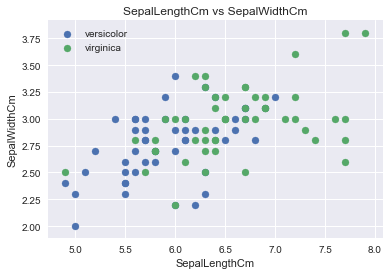

In [8]:
plt.scatter(iris_versicolor["SepalLengthCm"], iris_versicolor['SepalWidthCm'],label="versicolor")
plt.scatter(iris_virginica["SepalLengthCm"], iris_virginica['SepalWidthCm'],label="virginica")
plt.title("SepalLengthCm vs SepalWidthCm")
plt.xlabel("SepalLengthCm")
plt.ylabel("SepalWidthCm")
plt.legend(loc='best')
plt.show()

### PetalLengthCm と PetalWidthCm のプロット
品種ごとの花弁の長さと幅のプロット

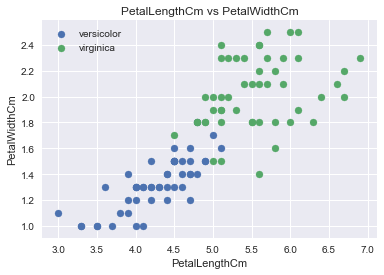

In [9]:
plt.scatter(iris_versicolor["PetalLengthCm"], iris_versicolor['PetalWidthCm'],label="versicolor")
plt.scatter(iris_virginica["PetalLengthCm"], iris_virginica['PetalWidthCm'],label="virginica")
plt.title("PetalLengthCm vs PetalWidthCm")
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc='best')
plt.show()

ともに正の相関があることがわかる。また** 花弁のほうが、品種の違いが明確 **である。

### ペアプロット（散布図行列）

In [10]:
pair_df = iris_df
pair_df=pair_df.drop(["Id"],axis=1)

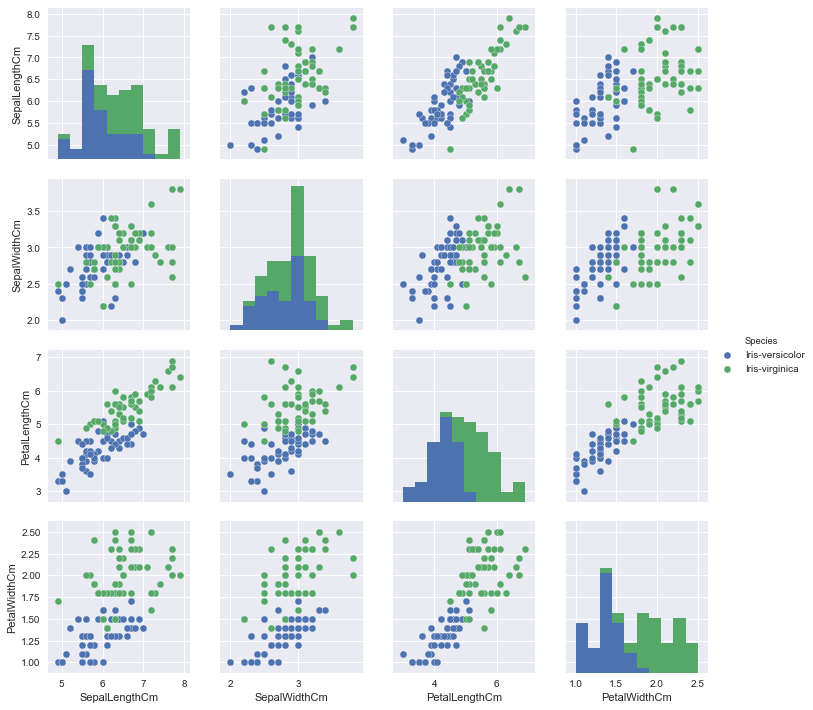

In [11]:
sns.pairplot(pair_df, hue='Species')

いずれも正の相関があることがわかる。また** 花弁（Petal）のほうが、品種の違いが明確 **である。

## 3. シグモイド関数について
### シグモイド関数の実装
$g(z) = \frac{1}{1 + e^{-z}}$

In [12]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

sigmoid(0.5)

0.6224593312018546

### なぜロジスティック回帰はシグモイド関数を用いるのか

前提として予測する出力が数値ではなくカテゴリーに属するかどうかの確率になる。  
このため、

- $h_\theta(x)$がどんな値を取ったときも0から1の値を取ることができる。
- $x_1 < x_2$のとき$h_\theta(x_1) < h_\theta(x_2)$が成り立つ。
- $\theta^Tx$ の正負で分類ができるので判定が簡単

上記を満たすためロジスティック関数ではシグモイド関数を用いる。

### シグモイド関数を描画

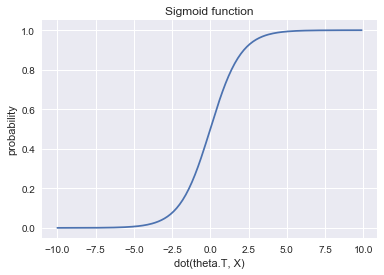

In [13]:
import math

x = np.arange(-10, 10, 0.1)
e = math.e

y = 1 / (1 + e**-x)

plt.plot(x, y)
plt.xlabel("dot(theta.T, X)")
plt.ylabel("probability")
plt.title("Sigmoid function")
plt.show()

### 正則化とは

モデルが複雑（高次数、多特徴量）であるほど、表現力が高くなり、実測値に対して過剰適合（過学習）を起こしやすくなる。  
正則化とは、各特徴量の係数に当たるパラメータ $\theta$（重み）の値を小さくさせ（ペナルティを与えて）、$\theta$が大きい値を取らないように補正することである。

## 4. 二乗誤差と交差エントロピー誤差について
なぜロジスティック回帰では二乗誤差ではなく交差エントロピー誤差関数を目的関数とするのか。

**回帰問題の目的は予測した誤差を最小にするのが目的であるのに対し、
分類問題の目的はそれぞれのデータがあるクラスと予測する確率を出し、すべてのデータで予測した分類が正解する、つまりそれぞれの事象の同時確率が最大になることが目的となるため。**

各データの同時確率（積集合）が目的関数になる。
これだとそれぞれ0~1の値を取るためデータ数が増えるとアンダーフローになり正しく判定できなくなる。
これを防ぐために対数をとった式が今回採用する交差誤差エントロピー誤差関数となる。
(合わせて正規化もできるというメリットもある。）


それぞれのデータのクラスに分類できる確率の同時確率は下記で表される。
この確率を最大化したい。

$J(\theta) = \frac{1}{m} \displaystyle \prod_{i=1}^m [y^{(i)}prob(x)^{(i)}+(1-y)^{(i)}(1-prob(x^{(i)}))]$

これだと各データの分類確率が0~1なのでかなり小さい値になってしまい、プログラム計算上不都合なので対数を取る。


$ J(\theta) = \frac{1}{m} log \displaystyle \prod_{i=1}^m [y^{(i)}prob(x)^{(i)}+(1-y)^{(i)}(1-prob(x^{(i)}))]$

$\log ab = \log a + \log b$ の性質より

$ J(\theta) = \frac{1}{m} log \displaystyle \prod_{i=1}^m [y^{(i)}prob(x)^{(i)}+(1-y)^{(i)}(1-prob(x^{(i)}))]$

### ロジスティック回帰における目的関数の実装

仮説関数  
$h_\theta(x) = g(\theta^T x)$

$g(z) = \frac{1}{1 + e^{-z}}$

目的関数  
$J(\theta) = \frac{1}{m} \displaystyle\sum_{i=1}^{m}[-y^{(i)} log(h_\theta(x^{(i)})) - (1 - y^{(i)}) log(1 - h_\theta(x^{(i)}))] +
\frac{\lambda}{2m} \displaystyle\sum_{j=1}^n
\theta^2_j$

In [14]:
# 切片追加
x_df["x0"] = 1
# 切片カラムを列の先頭に並び替え
x_df=x_df.iloc[:,[4,0,1,2,3]]

In [15]:
# 初期値パラメーター設定（切片含め特徴量が５つあるため）
theta = np.random.rand(5)

In [16]:
# 固有の要素を取得
y_df["Species"].unique()
# enumerate：インデックス番号、要素の順位に取得
class_mapping = {x:i for i, x in enumerate(y_df["Species"].unique())}
# カテゴリカルデータを数値に変換
# Iris-versicolor→0
# Iris-virginica→1
y_df["Species"]=y_df["Species"].map(class_mapping)

In [17]:
def compute_cost(X, y, theta, lam):
    
    # 仮説関数作成→各データの行列積を取得
    z=np.dot(X,theta)
    # シグモイド関数に代入
    sig=sigmoid(z)
    # 総データ数
    m=len(X)
    # 正則化項：regularization
    reg_term=(lam / (2*m))*(theta**2).sum()
    # 目的関数
    return (-1*y*np.log(sig) - (1 - y)*np.log(1 - sig)).sum() / m + reg_term

X=x_df
y=y_df["Species"]
lam=0.01

compute_cost(X, y, theta, lam)

2.2660783101734867

### 最急降下法（勾配降下法）の実装
$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}  ,j = 0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m} \displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} \biggr) + \frac{\lambda}{m}\theta_j　 ,j\geq 1$

In [18]:
def gradient_descent(X, y, theta, iterations, alpha, lam):

    # alpha：学習率（ステップ数）
    # iterations：反復回数
    
    past_costs = []
    past_thetas = []
    
    # j=0のとき、正則化項を0にする
    zero_or_one = np.ones(len(theta))
    zero_or_one[0]= 0
    
    # 総データ数
    m=len(X)
    
    for a in range(iterations):
        # 正則化項
        reg_term = lam * theta * zero_or_one
        z=np.dot(X,theta)
        sig=sigmoid(z)
        # パラメーター更新
        theta = theta - alpha / m * (np.dot(X.T, (sig - y)) + reg_term)
        past_costs.append(compute_cost(X, y, theta, lam))
        past_thetas.append(theta)
    return past_costs,past_thetas

alpha=0.01
iterations=200

(past_costs,past_thetas)=gradient_descent(X, y, theta, iterations, alpha, lam)

## 5. 学習曲線のプロット

In [19]:
def plot_learning_curve(X, y, theta, iterations, alpha, lam):
    # データを用意
    past_costs, past_thetas = gradient_descent(X, y, theta, iterations, alpha, lam)
    
    plt.plot(range(iterations), past_costs)
    plt.title('Learning Curve')
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.show()

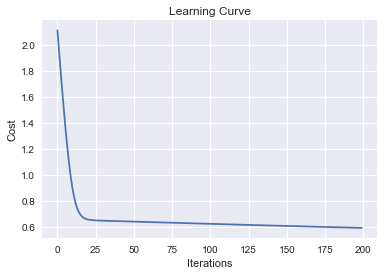

In [20]:
plot_learning_curve(X, y, theta, iterations, alpha, lam)

## 6. 予測関数について
学習済のモデルを使用して、実際に予測を行う関数を作成

### 各データの分類確率を求める

In [21]:
def predict_probs(X, theta):
    z=np.dot(X,theta)
    sig=sigmoid(z)
    return sig

In [22]:
# past_thetas[-1]：学習曲線で最も収束した時のパラメータを取得
predict_probs(X, past_thetas[-1])

array([0.43800943, 0.47047709, 0.47139263, 0.501827  , 0.48450518,
       0.50972976, 0.49759188, 0.45751405, 0.45650105, 0.50977137,
       0.47887837, 0.48670919, 0.44568076, 0.50494917, 0.44648872,
       0.43823526, 0.52802595, 0.44949917, 0.51582656, 0.46312604,
       0.55206726, 0.44739702, 0.52921509, 0.48975088, 0.44717022,
       0.44775739, 0.47093763, 0.51325077, 0.50577214, 0.41541367,
       0.46536543, 0.44886159, 0.45313207, 0.5655291 , 0.54073718,
       0.49869478, 0.46937816, 0.48033564, 0.48001667, 0.49530379,
       0.5123964 , 0.49429096, 0.46371659, 0.45441381, 0.49718804,
       0.47181592, 0.48428366, 0.45983138, 0.42890239, 0.48015366,
       0.66980797, 0.60479657, 0.59020657, 0.59452186, 0.62841488,
       0.60926185, 0.60590086, 0.58281947, 0.59673383, 0.61487771,
       0.55437622, 0.58209978, 0.58008011, 0.61880166, 0.64498351,
       0.60201262, 0.57174315, 0.59406675, 0.65327413, 0.56521524,
       0.59976498, 0.60856438, 0.60764504, 0.55024722, 0.59114

### 確率を閾値 0.5 で分類

In [23]:
# threshold：閾値
def predict(X, theta, threshold=0.5):
    # 各データの分類確率を取得
    probs=predict_probs(x_df, past_thetas[-1])
    species=[]
    for i in range(len(X)):
        if probs[i] >= threshold:
            species.append('Iris-virginica')
        else:
            species.append('Iris-versicolor')
    return species

In [24]:
# 予測分類データ
pred= predict(X,past_thetas[-1])

In [25]:
# 実測分類データ
real=iris_df["Species"].values.tolist()

In [26]:
# 正解率
count = 0
for i in range(len(pred)):
    if pred[i] == real[i]:
        count += 1
print('正解率：'+str(count/100))

正解率：0.87


## 7. クラス化

In [27]:
class LogisticModel():

    def __init__(self):
        pass
        
    def compute_cost(self, X, y, theta, lam):
        z=np.dot(X, theta)
        sig=sigmoid(z)
        m=len(X)
        reg_term=(lam / (2*m))*(theta**2).sum()
        return (-1*y*np.log(sig) - (1 - y)*np.log(1 - sig)).sum() / m + reg_term
    
    def gradient_descent(self, X, y, theta, iterations, alpha, lam):

        past_costs = []
        past_thetas = []
        zero_or_one = np.ones(len(theta))
        zero_or_one[0]= 0
        m=len(X)

        for a in range(iterations):
            reg_term = lam * theta * zero_or_one
            z=np.dot(X,theta)
            sig=sigmoid(z)
            theta = theta - alpha / m * (np.dot(X.T, (sig - y)) + reg_term)
            past_costs.append(self.compute_cost(X, y, theta, lam))
            past_thetas.append(theta)
        return past_costs, past_thetas
    
    def plot_learning_curve(self, X, y, theta, iterations, alpha, lam):
        past_costs, past_thetas = self.gradient_descent(X, y, theta, iterations, alpha, lam)

        plt.plot(range(iterations), past_costs)
        plt.title('Learning Curve')
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.show()

### 動作確認

In [28]:
# LinearModelオブジェクト作成
model = LogisticModel()
theta = np.random.rand(5)

alpha=0.01
lam=0.01
iterations=400

In [29]:
# 目的関数
model.compute_cost(X, y, theta, lam)

3.960603564039209

In [30]:
# 最急降下法
(past_costs,past_thetas)=model.gradient_descent(X, y, theta, iterations, alpha, lam)

In [31]:
pred= predict(x_df,past_thetas[-1])

# 正解率
count = 0
for i in range(len(pred)):
    if pred[i] == real[i]:
        count += 1
print("正解率："+str(count/100))

正解率：0.93


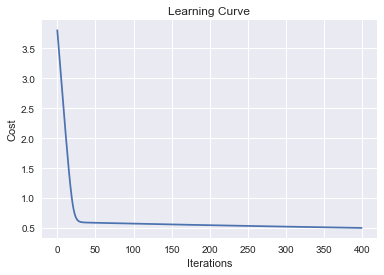

In [32]:
# 学習曲線
model.plot_learning_curve(X, y, theta, iterations, alpha, lam)

正常に動作していることを確認